In [67]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from IPython.display import display
import torchvision.models as models
import torchvision.datasets as datasets
from ignite.metrics import FID
from ignite.metrics import InceptionScore
import os
import math
from scipy.linalg import sqrtm

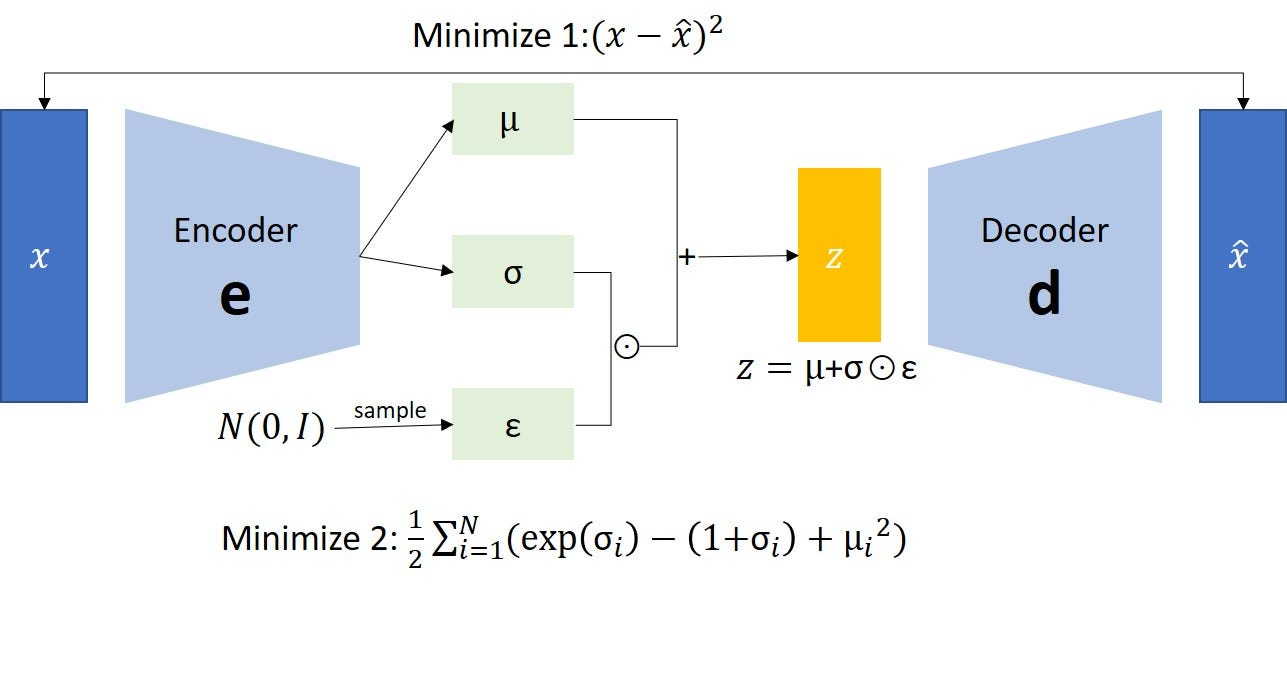

In [68]:
'''VAE Architecture'''
image_path = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/vae/architecture'  # Make sure to replace this with your image file path
image = Image.open(image_path)

display(image)

In [69]:
import sys
print(sys.executable)

/home/user/mambaforge/envs/vae/bin/python


In [70]:
'''A new enviornment is created using conda in the name 'vae' and the kernel is set accordingly to use this enviornment and
Python version so that while integrating tensorboard, there is no issue(If the version is >=3.9, some issues are happening)'''
import sys
print(sys.version)

3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) 
[GCC 12.3.0]


In [71]:
print(torch.__version__)

1.9.0+cu111


In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [73]:
device

'cuda'

In [74]:
'''Variational Auto Encoder class'''
class VAE(nn.Module):

    '''Here, the latent dimension size is taken as 1, which gives 2 values of mean and variance for each data sample'''
    def __init__(self, input_dim=784, hidden_dim1=400, hidden_dim2 = 200, latent_dim = 2, device=device):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2)
        )
        
        self.mean_layer = nn.Linear(hidden_dim2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim2, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


In [75]:
'''Example case '''
model1 = VAE()
data = torch.rand(32, 784)
mean,log_var = model1.encode(data)
mean = mean.to(device)
log_var = log_var.to(device)

In [76]:
print(mean.shape)
print(log_var.shape)

torch.Size([32, 2])
torch.Size([32, 2])


In [77]:
z = model1.reparameterization(mean,log_var)
print(z.shape)

torch.Size([32, 2])


In [78]:
def loss_function(x, x_hat, mean, log_var):
   
    '''Here, Binary cross entropy function is used to find the reconstruction loss since the input is noramlizd between 0 and 1. KLD is used
    as the stochastic loss term where it matches the prior and posterior distribution.'''
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # Compute the Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD


In [79]:
'''Downloading the MNIST dataset'''

path = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/vae/'
transform = transforms.Compose([transforms.ToTensor()]) #toTensor() makes the pixel values between 0 and 1
# Download the MNIST training dataset
train_dataset = datasets.MNIST(path, train=True, transform=transform, download=True)
# Download the MNIST test dataset
test_dataset = datasets.MNIST(path, train=False, transform=transform, download=True)

In [81]:
learning_rate = 1e-3
batch_size = 32
epochs = 15
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
print(len(train_loader.dataset)) #Gives the total number of samples in the dataset
print(len(test_loader.dataset))
print(len(train_loader)) #Gives the total number of batches 
print(len(test_loader))

60000
10000
1875
313


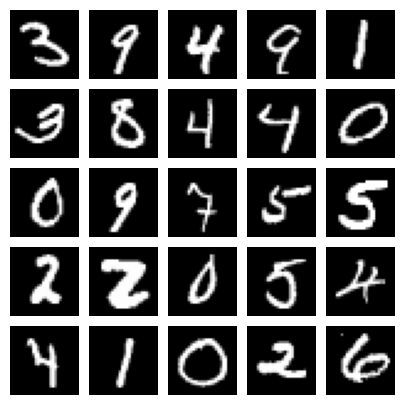

In [83]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = dataiter.next()
num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 
fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()


In [84]:
for x,y in train_loader:  #Here, train loader contains images and labels where x contains images and y contains digits
    print(y)
    print(x.shape)
    print
    break

tensor([9, 9, 1, 2, 4, 2, 0, 5, 2, 1, 4, 7, 2, 3, 4, 1, 5, 2, 2, 4, 0, 1, 7, 6,
        5, 9, 4, 1, 0, 8, 0, 5])
torch.Size([32, 1, 28, 28])


In [85]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [86]:
def train(model, optimizer, epochs, train_loader, test_loader, device):

    '''Training the data'''
    model.train()
    
    for epoch in range(epochs):
        overall_loss = 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, _) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}")

                x = x.to(device).view(x.size(0), -1)
                optimizer.zero_grad()
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)
                overall_loss += loss.item()
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=overall_loss / (batch_idx + 1))

        print(f"\tEpoch {epoch + 1} \tAverage Loss: {overall_loss / len(train_loader.dataset)}")

        '''Validation'''
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device).view(x.size(0), -1)
                x_hat, mean, log_var = model(x)
                test_loss += loss_function(x, x_hat, mean, log_var).item()

        test_loss /= len(test_loader.dataset)
        print(f'\tTest Loss: {test_loss}')

        model.train()  # Switch back to training mode

    return overall_loss


In [87]:
train(model, optimizer, epochs, train_loader,test_loader, device=device)

Epoch 1: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 193.40batch/s, loss=5.43e+3]


	Epoch 1 	Average Loss: 169.561394140625
	Test Loss: 159.91761857910157


Epoch 2: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 199.82batch/s, loss=5.05e+3]


	Epoch 2 	Average Loss: 157.72238787434895
	Test Loss: 155.71385065917968


Epoch 3: 100%|████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 186.36batch/s, loss=4.95e+3]


	Epoch 3 	Average Loss: 154.60778859049478
	Test Loss: 154.1566253173828


Epoch 4: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.62batch/s, loss=4.89e+3]


	Epoch 4 	Average Loss: 152.8332187093099
	Test Loss: 151.7285619140625


Epoch 5: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 191.99batch/s, loss=4.85e+3]


	Epoch 5 	Average Loss: 151.40627716878257
	Test Loss: 151.07874926757813


Epoch 6: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 189.35batch/s, loss=4.81e+3]


	Epoch 6 	Average Loss: 150.2866969563802
	Test Loss: 149.32219897460936


Epoch 7: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.53batch/s, loss=4.78e+3]


	Epoch 7 	Average Loss: 149.49261287434896
	Test Loss: 149.86763361816406


Epoch 8: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 191.94batch/s, loss=4.76e+3]


	Epoch 8 	Average Loss: 148.8379192138672
	Test Loss: 149.10689040527345


Epoch 9: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.53batch/s, loss=4.75e+3]


	Epoch 9 	Average Loss: 148.36348813476562
	Test Loss: 149.00900151367188


Epoch 10: 100%|███████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 197.24batch/s, loss=4.73e+3]


	Epoch 10 	Average Loss: 147.86867956136066
	Test Loss: 148.19215869140626


Epoch 11: 100%|███████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.93batch/s, loss=4.72e+3]


	Epoch 11 	Average Loss: 147.451733203125
	Test Loss: 148.43064135742188


Epoch 12: 100%|███████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 196.95batch/s, loss=4.71e+3]


	Epoch 12 	Average Loss: 147.05995550130208
	Test Loss: 147.84970803222657


Epoch 13: 100%|████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 196.87batch/s, loss=4.7e+3]


	Epoch 13 	Average Loss: 146.77424318440754
	Test Loss: 147.77523559570312


Epoch 14: 100%|███████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 197.56batch/s, loss=4.69e+3]


	Epoch 14 	Average Loss: 146.4458654622396
	Test Loss: 147.09494067382812


Epoch 15: 100%|███████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.92batch/s, loss=4.68e+3]


	Epoch 15 	Average Loss: 146.20034034016928
	Test Loss: 147.97804523925782


8772020.420410156

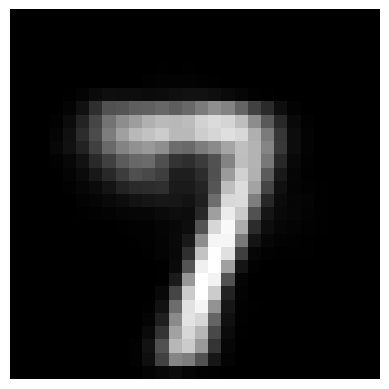

In [88]:
'''reconstruction'''
model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))  # Get the first batch
    x = x.to(device).view(x.size(0), -1)  # Reshape if necessary
    x_hat, mean, log_var = model(x)  # Forward pass
    digit = x_hat[0].detach().cpu().reshape(28, 28)  # Assuming 28x28 is the image size
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

   

In [89]:
'''Function to generate digits'''
def generate_digit(model, z1, z2, device='cpu'):

    
    # # Convert scalar mean and log_var to tensors
    # mean = torch.tensor([mean], device=device).float()
    # log_var = torch.tensor([var], device=device).float()
    # z = model.reparameterization(mean,log_var)

    '''Here, the z is directly defined as latent space for each sample will be of shape (1,2)'''
    z = torch.tensor([[z1, z2]], device = device).float()
    
    x_decoded = model.decode(z)

    # Convert the decoded tensor to an image for display
    digit = x_decoded.detach().cpu().reshape(28, 28)  # Assuming 28x28 is the image size
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()


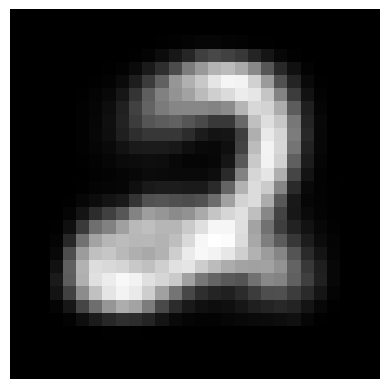

In [90]:
generate_digit(model, 0.0, 1.0, device = device)

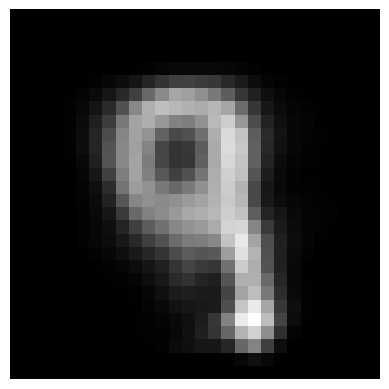

In [91]:
generate_digit(model,1.0,0.0, device = device)

In [92]:
def plot_latent_space(model, digit_size, scale=1.0, n=25, figsize=15):
    
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


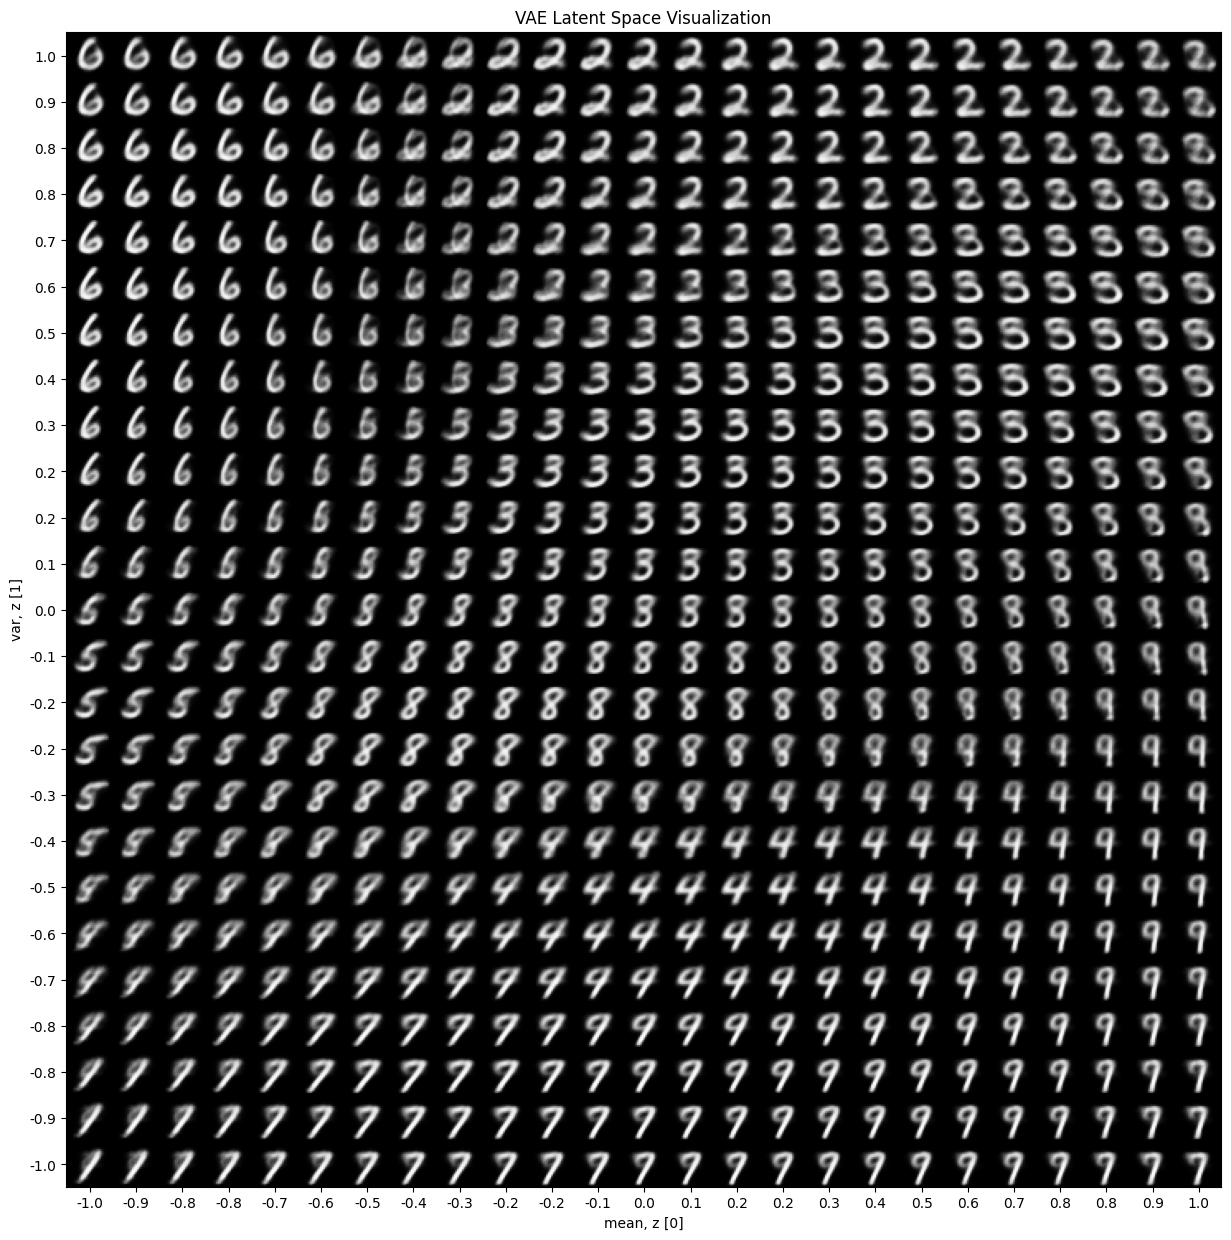

In [93]:
plot_latent_space(model,digit_size = 28) #here, the MNIST images have a shape of (1,28,28)

In [110]:
def save_generated_samples(model, z1, z2, save_path, device='cpu'):
    z = torch.tensor([[z1, z2]], device=device).float()
    x_decoded = model.decode(z)
    
    # Convert the decoded tensor to an image for display
    digit = x_decoded.detach().cpu().reshape(28, 28)  # Assuming 28x28 is the image size
    plt.imsave(save_path, digit, cmap='gray')

In [111]:
# Define the directory to save the images
save_dir = 'generated_digits_vae/generated_digits_vae'
os.makedirs(save_dir, exist_ok=True)

# Generate and save 60,000 images
for i in range(60000):
    z1, z2 = torch.randn(2)
    save_path = os.path.join(save_dir, f'digit_{i}.png')
    save_generated_samples(model, z1.item(), z2.item(), save_path, device=device)

In [112]:
torch.randn(2)

tensor([-1.2921,  0.1127])

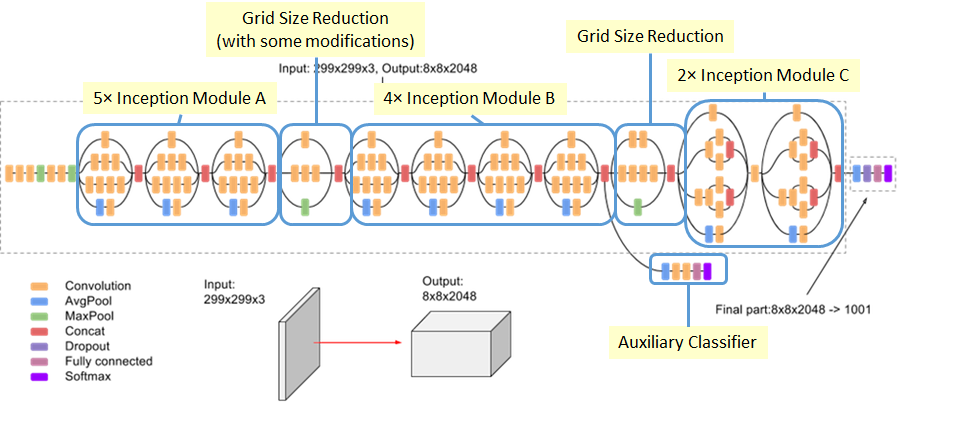

In [113]:
'''Architecture'''
image_path = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/vae/inception'  # Make sure to replace this with your image file path
image = Image.open(image_path)

display(image)

In [114]:
'''finetuning Inception-v3 model by changing the final layer (Learning/Demonstartion purpose)'''

# Load the Inception v3 model
inception_model = models.inception_v3(pretrained=True)
num_ftrs = inception_model.fc.in_features
print(num_ftrs)
num_classes = 10 #MNIST contains 10 classes(0-9)
inception_model.fc = nn.Linear(num_ftrs, num_classes)
num_epochs = 1
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = torch.optim.Adam(inception_model.parameters(), lr=0.001)
batch_size = 32

transform_inception = transforms.Compose([
    transforms.Resize(299),  # Inception v3 requires 299x299 images
    transforms.Grayscale(3),  # Convert 1-channel grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for Inception v3
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform_inception)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform_inception)
train_loader_inception = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader_inception = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

2048


In [115]:
for x,y in train_loader_inception:
    print(x.shape)
    break

torch.Size([32, 3, 299, 299])


In [100]:
device

device(type='cuda')

In [101]:
if torch.cuda.device_count() > 1: #Using multiple GPUs
    inception_model = nn.DataParallel(inception_model)

In [51]:
print(inception_model)

DataParallel(
  (module): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): Bas

In [52]:
def train_inception(inception_model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    
    inception_model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        train_loss = 0.0
        val_loss = 0.0
        inception_model.train()
        train_loop = tqdm(train_loader, leave=True)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Handle models with and without auxiliary outputs
            outputs = inception_model(inputs)
            if isinstance(outputs, tuple):  # Model provides auxiliary outputs
                output, aux_output = outputs
                loss1 = criterion(output, labels)
                loss2 = criterion(aux_output, labels)
                loss = loss1 + 0.4 * loss2
            else:  # No auxiliary outputs
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            train_loop.set_postfix(loss=loss.item())

        # Validation phase
        inception_model.eval()
        val_loop = tqdm(test_loader, leave=True)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = inception_model(inputs)
                if isinstance(outputs, tuple):  # Model provides auxiliary outputs
                    output, aux_output = outputs
                    loss1 = criterion(output, labels)
                    loss2 = criterion(aux_output, labels)
                    loss = loss1 + 0.4 * loss2
                else:  # No auxiliary outputs
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


In [53]:
train_inception(inception_model, train_loader_inception, test_loader_inception, criterion_inception, optimizer_inception, 
                num_epochs, device=device)

  0%|                                                                                          | 0/1875 [00:00<?, ?it/s]/home/user/mambaforge/envs/vae/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.83it/s, loss=0.000303]

Training Loss: 0.1484, Validation Loss: 0.0265


In [116]:
# Load the pretrained InceptionV3 model
inc_model = models.inception_v3(pretrained=True, aux_logits=False).to(device)
inc_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [117]:
# Create an ImageFolder dataset
gen_dir = 'generated_digits_vae'
gen_dataset = datasets.ImageFolder(root=gen_dir, transform=transform_inception)
gen_loader_inception = DataLoader(gen_dataset, batch_size=32, shuffle=True, num_workers=4)  # Adjust batch_siz

In [118]:
for x,_ in gen_loader_inception:
    print(x.shape)
    break

torch.Size([32, 3, 299, 299])


In [119]:
'''Function to extract the output of GLOBAL AVERAGE POOLING layer of inception-v3 model to calculate FID'''
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        # Extract the penultimate layer of the model
        self.model = nn.Sequential(*list(model.children())[:-1])
        #print(self.model)

    def forward(self, x):
        # Forward pass to the penultimate layer
        x = self.model(x)
        x = torch.flatten(x, start_dim=1)
        return x


In [120]:
'''Calculate FID Score using pytorch-ignite built-in function'''
feature_extractor = FeatureExtractor(inc_model).to(device)
fid_score = 0
fid = FID(feature_extractor=feature_extractor, num_features=2048, device=device)
assert len(train_loader_inception) == len(gen_loader_inception)

# Iterate over the real and generated images simultaneously
for (real_images, _), (gen_images, _) in tqdm(zip(train_loader_inception, gen_loader_inception), total=min(len(train_loader_inception), len(gen_loader_inception))):
    real_images = real_images.to(device)
    gen_images = gen_images.to(device)

    # Update FID with features from real and generated images
    fid.update((real_images, gen_images))

# Compute the FID score after going through all the batches
fid_score = fid.compute()
print(f"FID score: {fid_score}")


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [02:28<00:00, 12.62it/s]


FID score: 107.3192172725299


In [121]:
print(len(train_loader_inception))
print(len(gen_loader_inception))

1875
1875


In [122]:
# Initialize InceptionScore with default Inception model and 1000 classes
inception_score = InceptionScore(device=device)

# Assuming 'dataloader' is your DataLoader for generated images
for images, _ in tqdm(gen_loader_inception):
    inception_score.update(images)

# Compute the final Inception Score after processing all batches
score = inception_score.compute()
print(f"Inception Score: {score}")

100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.26it/s]

Inception Score: 2.0635518184187713


In [123]:
# Load the pretrained InceptionV3 model
im = models.inception_v3(pretrained=True, aux_logits=False).to(device)
im.eval()
im = nn.Sequential(*list(im.children())[:-1])
print(im)

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, moment

In [124]:
def compute_embeddings(dataloader, model, count):
    
    image_embeddings = []
    model = model.to(device)
    model.eval()
    
    for i, (images,lables) in tqdm(enumerate(dataloader), total=count):
        
        # Check if the images are in the expected tensor format
        if not isinstance(images, torch.Tensor):
            raise TypeError("The batch data is not in expected tensor format.")
        images = images.to(device)

        with torch.no_grad():
            embeddings = model(images)

        # Convert embeddings to CPU and detach from computation graph
        embeddings = embeddings.cpu().detach().numpy()
        image_embeddings.extend(embeddings)

        # Stop the loop after processing the desired number of batches
        if i + 1 == count:
            break

    return np.array(image_embeddings)


In [125]:
print(len(train_loader_inception.dataset))

60000


In [126]:
count = math.ceil(60000 / batch_size)
real_image_embeddings = compute_embeddings(train_loader_inception, im, count)
generated_image_embeddings = compute_embeddings(gen_loader_inception, im, count)

100%|██████████████████████████████████████████████████████████████████████████████▉| 1874/1875 [01:13<00:00, 25.59it/s]


In [127]:
print(real_image_embeddings.shape)

(60000, 2048, 1, 1)


In [128]:
'''calculation of fid using conventional method by implementing equation'''
def calculate_fid(real_embeddings, generated_embeddings):
    
    '''numpy arrays are given as input'''
    real_embeddings = real_embeddings.reshape(real_embeddings.shape[0],real_embeddings.shape[1])
    generated_embeddings = generated_embeddings.reshape(generated_embeddings.shape[0],real_embeddings.shape[1])
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calculate sqrt of product between covariances using sqrtm function from scipy
    covmean = sqrtm(sigma1.dot(sigma2)) 

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [129]:
fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
print(fid)

107.31921597462508


In [130]:
'''The FID Score might be large here due to many reasons. As the model is not trained on images like MNIST and trained
on ImageNet dataset, the feature-extraction itself wont be fruitful as we are not finetuning the inception-v3 model
Moreover, the final classification layer of inception-v3 module has 1000 neurons whereas MNIST has only 10 classes, but not finetuned also
by changing the final layer.'''

'The FID Score might be large here due to many reasons. As the model is not trained on images like MNIST and trained\non ImageNet dataset, the feature-extraction itself wont be fruitful as we are not finetuning the inception-v3 model\nMoreover, the final classification layer of inception-v3 module has 1000 neurons whereas MNIST has only 10 classes, but not finetuned also\nby changing the final layer.'

In [131]:
class VQVAE(nn.Module):   
    
    def __init__(self, in_channels, num_hiddens, num_embeddings, embedding_dim, commitment_cost):
        
        super(VQVAE, self).__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.num_embeddings = num_embeddings #K
        self.embedding_dim = embedding_dim #D
        self.commitment_cost = commitment_cost

        self.encoder_network = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 2, num_hiddens, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_hiddens, embedding_dim, kernel_size=1, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)

        self.decoder_network = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, num_hiddens, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x): #x--->(N,C,H,W)----->(N,D,H,W)
        
        return self.encoder_network(x) 

    def quantize(self, z):
        
        z = z.permute(0, 2, 3, 1).contiguous() #(N,D,H,W)--->(N,H,W,D)
        flat_z = z.view(-1, self.embedding_dim) #(N,H,W,D)--->(N*H*W,D)
        
        distances = torch.cdist(flat_z, self.embedding.weight) #(N*H*W,D)--->(N*H*W,K)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #(N*H*W,K)---->(N*H*W,1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z.device) #(N*H*W,1)---->(N*H*W,K)
        encodings.scatter_(1, encoding_indices, 1) #(N*H*W,K)
        embedding_vector = torch.matmul(encodings, self.embedding.weight).view(z.shape) #(N*H*W,K) x (K,D)----> (N*H*W,D)---->(N,H,W,D)
        
        codebook_loss = F.mse_loss(embedding_vector.detach(), z)
        commitment_loss = F.mse_loss(embedding_vector, z.detach())
        loss = codebook_loss + self.commitment_cost * commitment_loss
        
        quantized = z + (embedding_vector - z).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous() #(N,H,W,D)---->(N,D,H,W)
        
        return quantized, loss

    def decode(self, quantized): #(N,D,H,W)--->(N,C,H,W)
        
        return self.decoder_network(quantized)
        
    def forward(self, x):
        
        z = self.encode(x)
        quantized, loss = self.quantize(z)
        x_recon = self.decode(quantized)
        return x_recon, loss


In [132]:
def train_vqvae(model, data_loader, optimizer, data_variance, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}')

        for (x, _) in progress_bar:
            x = x.to(device)
            
            # Forward pass
            x_recon, loss = model(x)

            # Backpropagation
            optimizer.zero_grad()
            loss_recon = F.mse_loss(x_recon, x) / data_variance
            total_loss_step = loss + loss_recon
            total_loss_step.backward()
            optimizer.step()

            total_loss += total_loss_step.item()
            progress_bar.set_postfix(loss=(total_loss / len(data_loader)))

        print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(data_loader)}')

In [133]:
data_variance = np.var(train_dataset.data.numpy() / 255.0)

In [134]:
vqvae_model = VQVAE(in_channels=1, num_hiddens=128, num_embeddings=512, embedding_dim=64, commitment_cost=0.25).to(device)
optimizer_vqvae = torch.optim.Adam(vqvae_model.parameters(), lr=1e-3)
train_vqvae(vqvae_model, train_loader, optimizer_vqvae, data_variance)

Epoch 1: 100%|██████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 155.50it/s, loss=2.38]


Epoch 1, Average Loss: 2.384986407351494


Epoch 2: 100%|█████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 154.36it/s, loss=0.129]


Epoch 2, Average Loss: 0.12935201151768366


Epoch 3: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 156.32it/s, loss=0.0868]


Epoch 3, Average Loss: 0.08683251519203186


Epoch 4: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 154.02it/s, loss=0.0727]


Epoch 4, Average Loss: 0.07269159002105395


Epoch 5: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 154.73it/s, loss=0.0662]


Epoch 5, Average Loss: 0.06619091415405273


Epoch 6: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 153.27it/s, loss=0.0646]


Epoch 6, Average Loss: 0.06460596491495768


Epoch 7: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 154.74it/s, loss=0.0629]


Epoch 7, Average Loss: 0.0628863993048668


Epoch 8: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 157.24it/s, loss=0.0619]


Epoch 8, Average Loss: 0.06185423952142398


Epoch 9: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 157.23it/s, loss=0.0611]


Epoch 9, Average Loss: 0.06106047172347705


Epoch 10: 100%|███████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 156.46it/s, loss=0.0604]

Epoch 10, Average Loss: 0.060423085433244705


In [135]:
vqvae_model.eval()
for (x,y) in train_loader:
    x = x.to(device)
    z = vqvae_model.encode(x)
    print(z.shape)
    break

torch.Size([32, 64, 9, 9])


'Here, the prior is not wrapped with a AR funcrtion like PixelCNN and trained. So, it is not suitable for generation.'

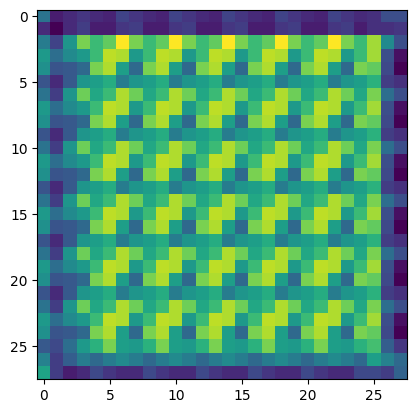

In [136]:
'''Generation'''
vqvae_model.eval()

# Directory where images will be saved
save_dir_vqvae = 'save_dir_vqvae'
os.makedirs(save_dir_vqvae, exist_ok=True)

for i in range(1):
    # Sample a latent vector from the embedding space
    sample_idx = torch.randint(0, vqvae_model.num_embeddings, (1,), device=device)
    sample_z = vqvae_model.embedding(sample_idx).view(1,vqvae_model.embedding_dim).to(device) #(1,D)
    sample_z = sample_z.unsqueeze(2).unsqueeze(3)  # change shape from (1, 64) to (1, 64, 1, 1)
    expanded_z = sample_z.expand(-1, -1, 9, 9).to(device)  # expand to (1, 64, 9, 9) 

    # Generate an image
    with torch.no_grad():
        generated_image = vqvae_model.decode(expanded_z).view(1,1,28,28)
    # Convert image tensor to PIL image and save
    img = transforms.ToPILImage()(generated_image.squeeze(0).cpu())
    plt.imshow(img)
    img.save(os.path.join(save_dir, f'generated_{i}.png'))

'''Here, the prior is not wrapped with a AR funcrtion like PixelCNN and trained. So, it is not suitable for generation.'''
 

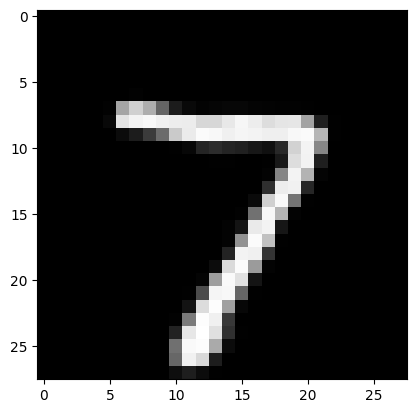

In [138]:
for (x, _) in test_loader:
    x = x.to(device)
            
    # Forward pass
    with torch.no_grad():
        x_recon, loss = vqvae_model(x)
        for i in x_recon:
            img = transforms.ToPILImage()(i.squeeze(0).cpu())
            plt.imshow(img,cmap='gray')
            break
    break